# 11. Decision Trees and Ensemble Models (Bagging & Boosting)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

In [3]:
#y will be loan_status (Categorical)(Fully Paid/ Charged Off(our default), Current, etc.)
df = pd.read_csv("data/data11_LoansData.csv") 
df.shape

C:\Users\soyyo\AppData\Local\Temp\ipykernel_28760\4098089787.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/data11_LoansData.csv")


(100000, 150)

In [4]:
df['loan_status'].value_counts(dropna=False)  #dropna default is True but we will set it to False not to lose rows

loan_status
Fully Paid            69982
Charged Off           16156
Current               12726
Late (31-120 days)      730
In Grace Period         264
Late (16-30 days)       139
Default                   3
Name: count, dtype: int64

In [5]:
df = df.loc[df['loan_status'].isin(['Fully Paid','Charged Off'])]
df['loan_status'].value_counts(dropna=False, normalize= True) #shows fractions

loan_status
Fully Paid     0.812441
Charged Off    0.187559
Name: proportion, dtype: float64

In [6]:
df['charged_off'] = df['loan_status'].map(lambda x:1 if 'Charged Off' in x else 0)
df['charged_off'].describe()

count    86138.000000
mean         0.187559
std          0.390362
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: charged_off, dtype: float64

In [7]:
df.drop('loan_status',axis=1,inplace=True)

In [8]:
#Feature Exploration
keep_list = ['charged_off','dti','earliest_cr_line','fico_range_high','home_ownership','int_rate','term','sub_grade','last_pymnt_amnt','avg_cur_bal','acc_open_past_24mths']
df = df[keep_list]
df.shape

(86138, 11)

In [9]:
corr = df.corr()
corr

ValueError: could not convert string to float: 'Aug-94'

In [10]:
df['term'].value_counts()

term
 36 months    67507
 60 months    18631
Name: count, dtype: int64

In [11]:
df['term'] = df['term'].map(lambda x:36 if '36 months' in x else 60)
df.groupby('term')['charged_off'].value_counts(normalize=True).loc[:,1]

term
36    0.141526
60    0.354356
Name: proportion, dtype: float64

<Axes: xlabel='sub_grade'>

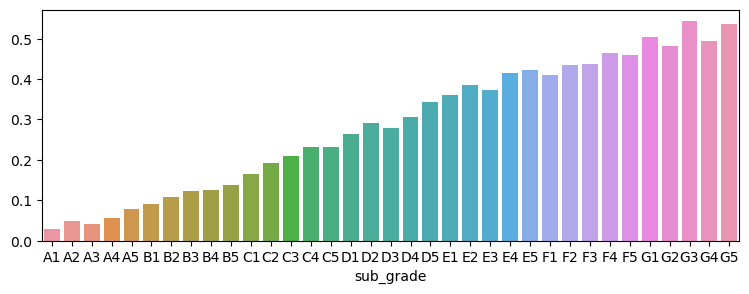

In [12]:
chargedoff_rate_sg=df.groupby('sub_grade')['charged_off'].value_counts(normalize=True).loc[:,1]
plt.figure(figsize=(9,3))
sns.barplot(x=chargedoff_rate_sg.index, y=chargedoff_rate_sg.values)

In [13]:
cat_mask= df.dtypes==object  #Boolean 1 & 0
cat_cols =df.columns[cat_mask].tolist()
cat_cols

['earliest_cr_line', 'home_ownership', 'sub_grade']

In [14]:
df['earliest_cr_line_code'] = LabelEncoder().fit_transform(df.earliest_cr_line)
df['home_ownership_code'] = LabelEncoder().fit_transform(df.home_ownership)
df['sub_grade_code'] = LabelEncoder().fit_transform(df.sub_grade)

In [15]:
df.drop(cat_cols, axis=1, inplace=True)
df.shape

(86138, 11)

In [16]:
y=df['charged_off']
x=df.loc[:,df.columns != 'charged_off']

x_train, x_test, y_train, y_test =  train_test_split(x,y, test_size=0.2, random_state=101)

Accuracy Score = 0.8529719061992106
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     14004
           1       0.61      0.61      0.61      3224

    accuracy                           0.85     17228
   macro avg       0.76      0.76      0.76     17228
weighted avg       0.85      0.85      0.85     17228



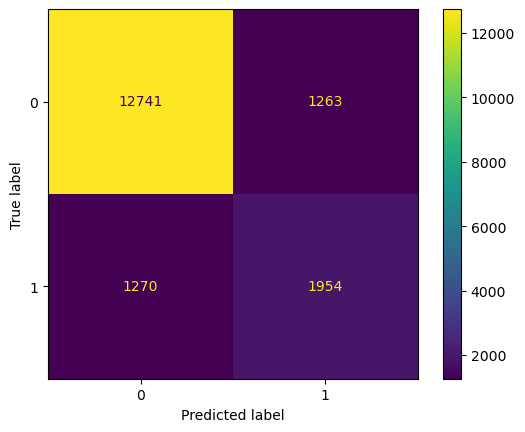

In [19]:
dtc = DecisionTreeClassifier(random_state=101)
dtc.fit(x_train, y_train)

ConfusionMatrixDisplay.from_estimator(dtc, x_test, y_test)

y_pred = dtc.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(f'Accuracy Score = {score}')
print(classification_report(y_test, y_pred))   #We want to minimize Type 2 error: False Negative(who really default but couldn't capture)

In [20]:
dtc.feature_importances_

array([0.09303907, 0.04419151, 0.03821338, 0.18597631, 0.37205171,
       0.0919634 , 0.03612465, 0.07992057, 0.01164936, 0.04687003])

In [21]:
for name, val in zip(x_train.columns, dtc.feature_importances_): 
    print(f'{name} importance = {val:.2%}')

dti importance = 9.30%
fico_range_high importance = 4.42%
int_rate importance = 3.82%
term importance = 18.60%
last_pymnt_amnt importance = 37.21%
avg_cur_bal importance = 9.20%
acc_open_past_24mths importance = 3.61%
earliest_cr_line_code importance = 7.99%
home_ownership_code importance = 1.16%
sub_grade_code importance = 4.69%


[Text(0.5, 0.875, 'last_pymnt_amnt <= 1078.215\ngini = 0.305\nsamples = 68910\nvalue = [55978, 12932]\nclass = 0'),
 Text(0.25, 0.625, 'term <= 48.0\ngini = 0.469\nsamples = 33323\nvalue = [20790, 12533]\nclass = 0'),
 Text(0.125, 0.375, 'sub_grade_code <= 9.5\ngini = 0.39\nsamples = 27571\nvalue = [20238, 7333]\nclass = 0'),
 Text(0.0625, 0.125, 'gini = 0.276\nsamples = 14098\nvalue = [11771, 2327]\nclass = 0'),
 Text(0.1875, 0.125, 'gini = 0.467\nsamples = 13473\nvalue = [8467, 5006]\nclass = 0'),
 Text(0.375, 0.375, 'last_pymnt_amnt <= 198.88\ngini = 0.174\nsamples = 5752\nvalue = [552, 5200]\nclass = 1'),
 Text(0.3125, 0.125, 'gini = 0.443\nsamples = 450\nvalue = [301, 149]\nclass = 0'),
 Text(0.4375, 0.125, 'gini = 0.09\nsamples = 5302\nvalue = [251, 5051]\nclass = 1'),
 Text(0.75, 0.625, 'last_pymnt_amnt <= 1341.91\ngini = 0.022\nsamples = 35587\nvalue = [35188, 399]\nclass = 0'),
 Text(0.625, 0.375, 'sub_grade_code <= 14.5\ngini = 0.271\nsamples = 1724\nvalue = [1445, 279]\nclas

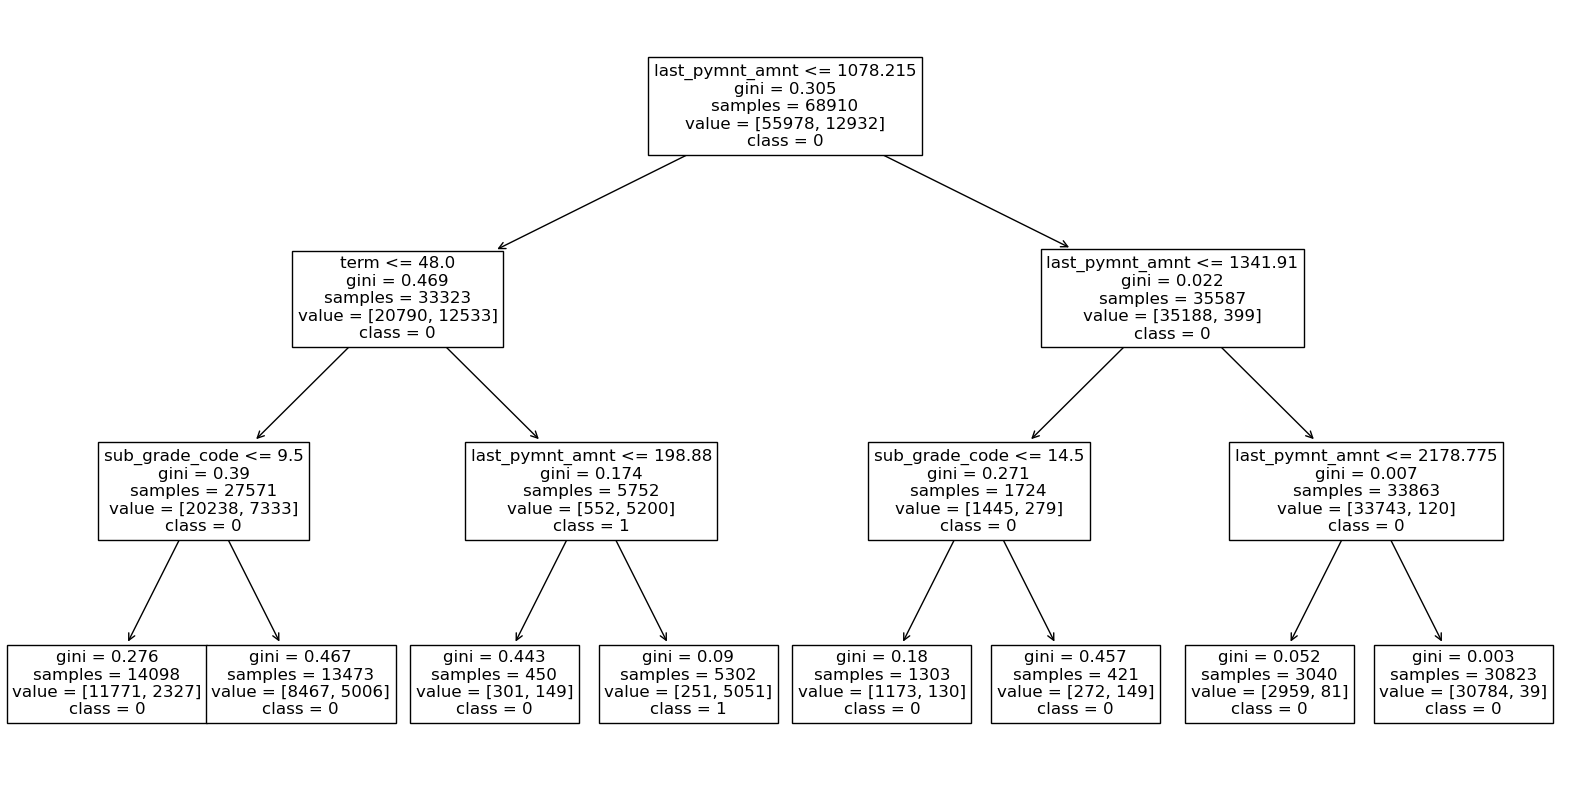

In [22]:
dtc = DecisionTreeClassifier(random_state=101, max_depth=3)
dtc.fit(x_train, y_train)

plt.figure(figsize=(20,10))
plot_tree(dtc, feature_names=x_train.columns, class_names=['0','1'], fontsize=12)